In [1]:
import pandas as pd
from plot_params import *
from pathlib import Path
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

from pathlib import Path
config = load(open('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/notebook_protocol/configs/4_EVs.yaml'), Loader=Loader)
basedir = Path(config['workdir'])




In [2]:
rename_dict = { 
               '3779_EV': 'Placental EV 1',
               '3833_EV':'Placental EV 2',
                '3845_EV':'Placental EV 3',
               ### included
               }

In [3]:
ciri_stat = pd.read_csv(basedir/'output/circle_summary/ciri_stats.csv').set_index('##Sample').rename(rename_dict)
circ_counts = pd.read_csv(basedir/'output/circle_summary/circ_type_counts.csv', index_col = 0).rename(rename_dict)

bsj = pd.read_csv(basedir/'output/circle_summary/BSJ_counts.csv', index_col = 0).rename(rename_dict, axis = 1)
fsj = pd.read_csv(basedir/'output/circle_summary/FSJ_counts.csv', index_col = 0).rename(rename_dict, axis = 1)
bsj_cpm=bsj.div(ciri_stat['##Total_Reads'], axis = 1)*10**6
fsj_cpm=fsj.div(ciri_stat['##Total_Reads'], axis = 1)*10**6
annotation = pd.read_csv(basedir / 'output/circle_summary/all_circle_annotation.csv')

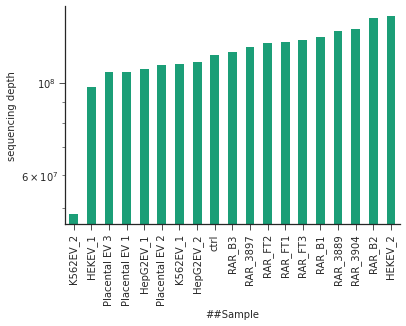

In [4]:
ciri_stat['##Total_Reads'].sort_values().plot.bar()
plt.ylabel('sequencing depth')
plt.yscale('log')
sns.despine()

In [5]:
ciri_stat.index

Index(['RAR_B3', 'RAR_FT2', 'RAR_3889', 'RAR_FT1', 'RAR_B1', 'RAR_B2',
       'RAR_3897', 'RAR_FT3', 'RAR_3904', 'K562EV_2', 'HEKEV_1', 'HepG2EV_2',
       'HepG2EV_1', 'Placental EV 3', 'K562EV_1', 'HEKEV_2', 'Placental EV 1',
       'Placental EV 2', 'ctrl'],
      dtype='object', name='##Sample')

In [6]:
to_include = ['K562EV_2', 'HEKEV_1', 'HepG2EV_2',
       'HepG2EV_1', 'K562EV_1', 'HEKEV_2', 'Placental EV 1', 'Placental EV 2','Placental EV 3',
       'ctrl']

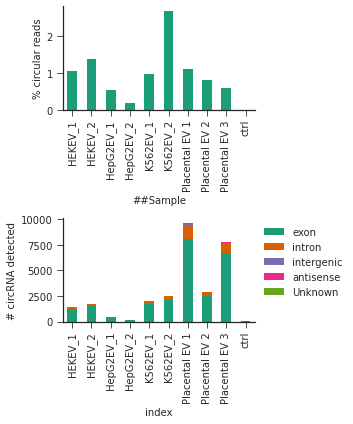

In [7]:
f, ax = plt.subplots(2,1, figsize = (6,6))
(ciri_stat.loc[to_include,'frac_circular']*100).sort_index().plot.bar(
    ax = ax[0])
ax[0].set_ylabel('% circular reads')

circ_counts.loc[to_include].sort_index().plot.bar(stacked = True, ax = ax[1])
ax[1].set_ylabel('# circRNA detected')
ax[1].legend(bbox_to_anchor = (1.5,1))
sns.despine()
plt.tight_layout()
plt.savefig(figdir/'EV_basic_stats.pdf')
# ctrl is just culture media

In [8]:
circ_counts.sum(axis = 1)

index
RAR_B3             656.0
RAR_FT2            413.0
RAR_3889          3835.0
RAR_FT1            525.0
RAR_B1             563.0
RAR_B2             628.0
RAR_3897          6800.0
RAR_FT3            565.0
RAR_3904          7511.0
K562EV_2          2533.0
HEKEV_1           1404.0
HepG2EV_2          175.0
HepG2EV_1          501.0
Placental EV 3    7782.0
K562EV_1          2016.0
HEKEV_2           1713.0
Placental EV 1    9609.0
Placental EV 2    2927.0
ctrl                18.0
dtype: float64

# PCA

In [9]:
import numpy as np
from sklearn.decomposition import PCA

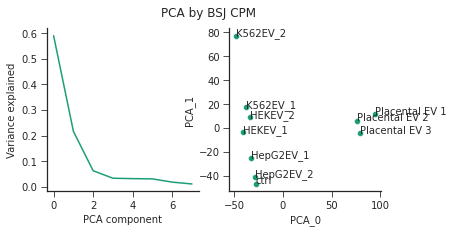

In [10]:
fraction_detected = 0.5
sub = bsj_cpm[to_include]
ncomp = min(8,sub.shape[1]-1)
common_circ = sub.loc[sub.count(axis = 1)>sub.shape[1]*fraction_detected].fillna(0)
pca = PCA(n_components=ncomp)
transformed = pca.fit_transform(common_circ.T)
transformed_df = pd.DataFrame(transformed, index = sub.columns, columns = [f'PCA_{i}' for i in range(ncomp)])

f, ax = plt.subplots(1,2, figsize = (6,3))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_ylabel('Variance explained')
ax[0].set_xlabel('PCA component')

sns.scatterplot(data = transformed_df, x = 'PCA_0', y = 'PCA_1', ax = ax[1])
for index, row in transformed_df.iterrows():
    ax[1].text(row['PCA_0'], row['PCA_1'], index)
sns.despine()
plt.suptitle('PCA by BSJ CPM')
plt.savefig(figdir/'EV_PCA.pdf')

Text(0.5, 0.98, 'PCA by FSJ CPM')

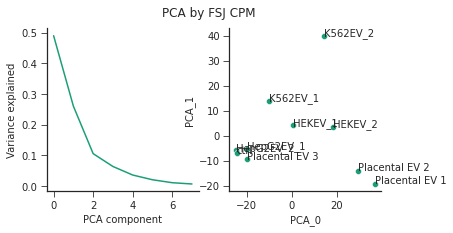

In [11]:
fraction_detected = 0.5
sub = fsj_cpm[to_include]
ncomp = min(8,sub.shape[1]-1)
common_circ = sub.loc[sub.count(axis = 1)>sub.shape[1]*fraction_detected].fillna(0)
pca = PCA(n_components=ncomp)
transformed = pca.fit_transform(common_circ.T)
transformed_df = pd.DataFrame(transformed, index = sub.columns, columns = [f'PCA_{i}' for i in range(ncomp)])

f, ax = plt.subplots(1,2, figsize = (6,3))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_ylabel('Variance explained')
ax[0].set_xlabel('PCA component')

sns.scatterplot(data = transformed_df, x = 'PCA_0', y = 'PCA_1', ax = ax[1])
for index, row in transformed_df.iterrows():
    ax[1].text(row['PCA_0'], row['PCA_1'], index)
sns.despine()
plt.suptitle('PCA by FSJ CPM')


# Look at reproducible EVs

In [12]:
detected = ~bsj.isnull()

In [13]:
detected.head()

,RAR_B3,RAR_FT2,RAR_3889,RAR_FT1,RAR_B1,RAR_B2,RAR_3897,RAR_FT3,RAR_3904,K562EV_2,HEKEV_1,HepG2EV_2,HepG2EV_1,Placental EV 3,K562EV_1,HEKEV_2,Placental EV 1,Placental EV 2,ctrl
circ_id,,,,,,,,,,,,,,,,,,,
chr1:805799|810170,True,True,True,False,False,False,True,False,True,False,False,False,False,True,False,False,True,True,False
chr1:1223244|1223968,True,False,True,False,False,True,True,False,True,True,True,False,False,True,True,False,True,True,False
chr1:2302978|2304585,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
chr1:6820181|6888899,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False
chr1:8556475|8614686,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
reproducible = {}
for cline in ['K562', 'HEK', 'HepG2']:
    reproducible[cline]=set(detected.loc[detected[f'{cline}EV_2']&detected[f'{cline}EV_1']].index)
reproducible['placenta']=set(detected.loc[detected['Placental EV 1']&detected['Placental EV 2']&detected['Placental EV 3']].index.tolist())
reproducible['ctrl']=set(detected.loc[detected['ctrl']].index.tolist())

In [15]:
import pickle
with open('reproducible_EV.pickle', 'wb') as handle:
    pickle.dump(reproducible, handle)

In [16]:
reproducible_cnt = []
for cline in reproducible:
    cnt = annotation.loc[annotation['circ_id'].isin(reproducible[cline]), 'circ_type'].value_counts()
    cnt.name = cline
    reproducible_cnt.append(cnt)
reproducible_cnt = pd.concat(reproducible_cnt, axis = 1).fillna(0)

In [17]:
reproducible_cnt.sum(axis = 0)

K562         466.0
HEK          253.0
HepG2         25.0
placenta    1233.0
ctrl          18.0
dtype: float64

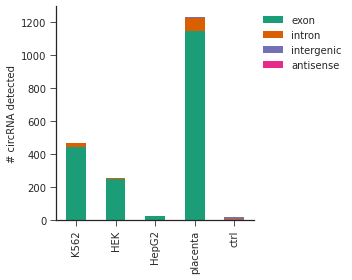

In [18]:
f, ax = plt.subplots(figsize = (5,4))
reproducible_cnt.T.plot.bar(stacked = True, ax = ax)
ax.set_ylabel('# circRNA detected')
ax.legend(bbox_to_anchor = (1,1))
sns.despine()
plt.tight_layout()
plt.savefig(figdir/'EV_reproducible_circles.pdf')

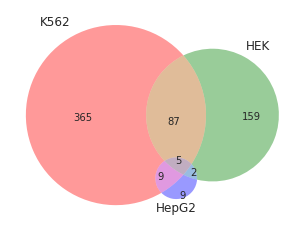

In [19]:
from matplotlib_venn import venn3
labels = ['K562', 'HEK', 'HepG2']
venn3([reproducible[cline] for cline in labels],
      set_labels = labels)
plt.savefig(figdir/'EV_venn_clines.pdf')

In [20]:
cellline_reproducible_evs = annotation.loc[annotation['circ_id'].isin(reproducible['K562'].intersection(
    reproducible['HEK']).intersection(
    reproducible['HepG2']))]

In [21]:
# for i in sam_landry:
#     print(i)
#     print(sam_landry[i].intersection(set(cellline_reproducible_evs['gene_name'])))

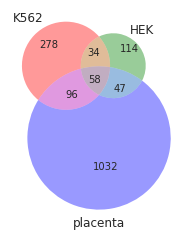

In [22]:
from matplotlib_venn import venn3
labels = ['K562', 'HEK', 'placenta']
labels = ['K562', 'HEK', 'placenta']
venn3([reproducible[cline] for cline in labels],
      set_labels = labels)
plt.savefig(figdir/'EV_venn_placenta.pdf')

In [23]:
reproducible_cnt.sum(axis = 0)

K562         466.0
HEK          253.0
HepG2         25.0
placenta    1233.0
ctrl          18.0
dtype: float64

In [24]:
(96+58)/466

0.33047210300429186

In [25]:
(58+47)/253

0.4150197628458498

In [26]:
58/reproducible_cnt.sum(axis = 0)

K562        0.124464
HEK         0.229249
HepG2       2.320000
placenta    0.047040
ctrl        3.222222
dtype: float64

# Looking at EVs

In [27]:
if config['circ_de']:
    de_path = list((basedir / 'output/circ_de_reps').glob('*.gtf.tsv'))+list((basedir / 'output/circ_de').glob('*.gtf.tsv'))


In [28]:
reproducible.keys()

dict_keys(['K562', 'HEK', 'HepG2', 'placenta', 'ctrl'])

In [29]:
de_path

[PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/placenta_vs_HEK.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/K562_vs_HEK.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/preeclampsia_vs_healthy.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HepG2_EV_vs_all.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HEK_EV_vs_all.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HepG2_vs_HEK.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/PLAP.gtf.tsv'),
 PosixPath('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/K562_EV_vs_all.gtf.tsv')]

In [30]:
!head /tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/placenta_vs_HEK.gtf.tsv

,logFC,logCPM,LR,PValue,DE,FDR
chr5:137985257|137988315,15.6212243638565,7.07777243800163,14.5513022417591,0.00013639434951806,0,0.355049558731609
chr12:46239679|46243314,15.4839577670308,6.94057322943445,14.3249069405129,0.000153816232959364,0,0.355049558731609
chr15:80120328|80122800,15.2856906669122,6.74241345849452,14.0021891437663,0.000182597914941476,0,0.355049558731609
chr22:16637040|16638740,15.0546506510326,6.51154249781574,13.632418558914,0.000222313315758608,0,0.355049558731609
chr2:72731007|72733118,15.0109682985574,6.46787821347971,13.56325963817,0.000230656181446737,0,0.355049558731609
chr8:98706467|98707311,14.513555497258,5.97091889896134,12.7922471174822,0.000348058784118492,0,0.355049558731609
chr12:111552280|111555919,14.4226631037625,5.88015022214239,12.6545839376678,0.00037464596094902,0,0.355049558731609
chr3:111144899|111147484,14.2810162818714,5.73862820095525,12.4420099894494,0.000419783775039807,0,0.355049558731609
chr11:86022367|86031611,14.0284552231146,5.48

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/placenta_vs_HEK.gtf.tsv
placenta_vs_HEK -1
placenta_vs_HEK 1


/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


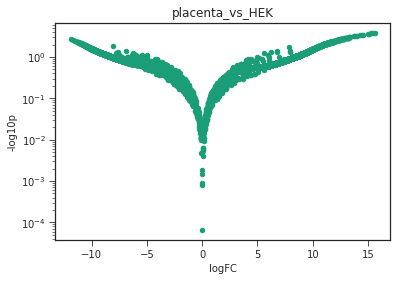

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/K562_vs_HEK.gtf.tsv


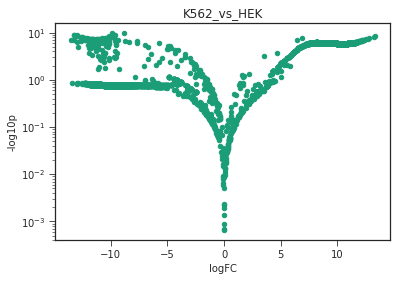

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/preeclampsia_vs_healthy.gtf.tsv
preeclampsia_vs_healthy -1
preeclampsia_vs_healthy 1


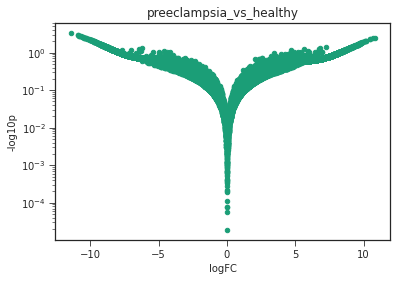

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HepG2_EV_vs_all.gtf.tsv


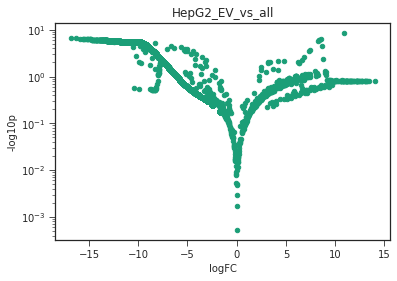

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HEK_EV_vs_all.gtf.tsv


/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


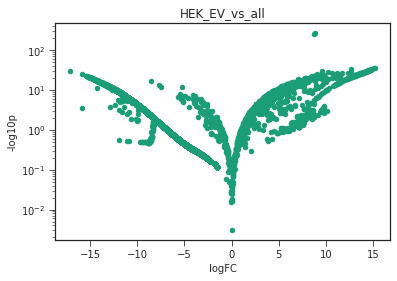

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/HepG2_vs_HEK.gtf.tsv
HepG2_vs_HEK -1
HepG2_vs_HEK 1


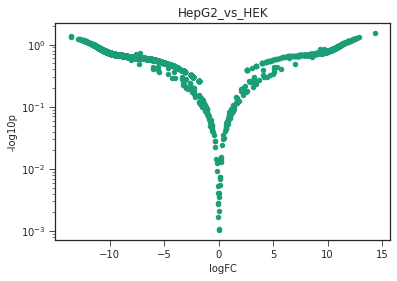

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/PLAP.gtf.tsv
PLAP -1
PLAP 1


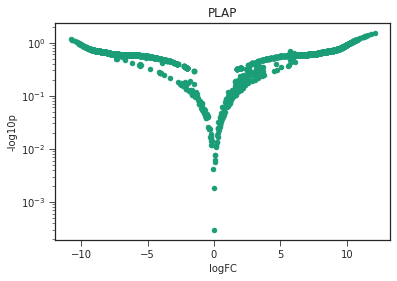

/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/4_EVs/output/circ_de_reps/K562_EV_vs_all.gtf.tsv


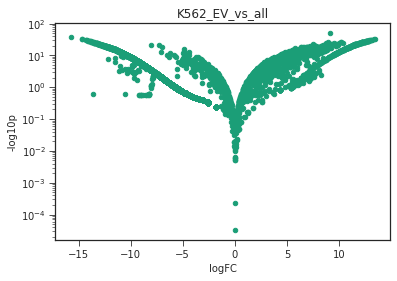

In [31]:
de_dict = {}
neg_cnt = []
pos_cnt = []
for f in de_path:
    print(f)
    name = f.name.split('.')[0]
    de_df = pd.read_csv(f, sep = ',', index_col = 0)
    de_df = de_df.merge(annotation, left_index = True, right_on = ['circ_id'])
    de_dict[name] = de_df

    
    cnts = pd.pivot_table(de_df, index = 'DE', columns = 'circ_type', aggfunc = 'size').fillna(0)
    try:
        neg=cnts.loc[-1]
        neg.name = name
        
    
        
    except Exception as e:
        neg = pd.Series()
        neg.name = name
        print(name, e)
    neg_cnt.append(neg)
    try:
        pos=cnts.loc[1]
        pos.name = name
        
    except Exception as e:
        pos = pd.Series()
        pos.name = name
        print(name, e)
    pos_cnt.append(pos)

    
    de_df['-log10p']=-np.log10(de_df['PValue'])
    de_df.plot.scatter(x = 'logFC', y = '-log10p')
    plt.yscale('log')
    plt.title(name)
    plt.show()
neg_cnt = pd.concat(neg_cnt, axis = 1)
pos_cnt = pd.concat(pos_cnt, axis = 1)

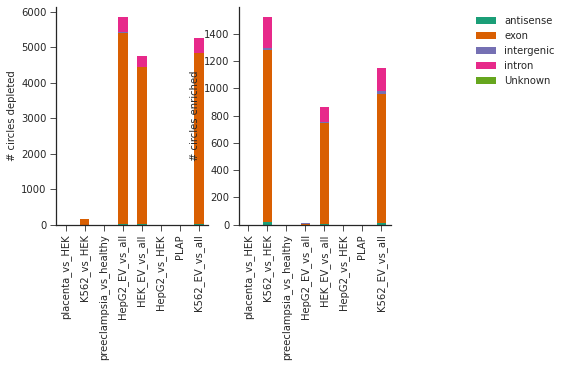

In [34]:
f, ax = plt.subplots(1,2)
neg_cnt.T.plot.bar(stacked = True, ax = ax[0], legend = False)
ax[0].set_ylabel('# circles depleted')
pos_cnt.T.plot.bar(stacked = True, ax = ax[1])
ax[1].set_ylabel('# circles enriched')
ax[1].legend(bbox_to_anchor = (1.5,1))
sns.despine()

In [35]:
pos_cnt

,placenta_vs_HEK,K562_vs_HEK,preeclampsia_vs_healthy,HepG2_EV_vs_all,HEK_EV_vs_all,HepG2_vs_HEK,PLAP,K562_EV_vs_all
antisense,NaN,18.0,NaN,0.0,1.0,NaN,NaN,15.0
exon,NaN,1260.0,NaN,6.0,745.0,NaN,NaN,946.0
intergenic,NaN,18.0,NaN,2.0,10.0,NaN,NaN,17.0
intron,NaN,224.0,NaN,2.0,109.0,NaN,NaN,174.0
Unknown,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0


Text(0, 0.5, '# circles enriched')

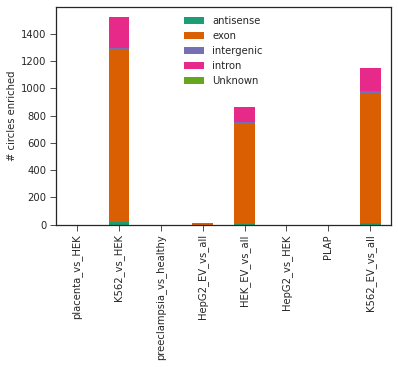

In [33]:
pos_cnt.T.plot.bar(stacked = True)
plt.ylabel('# circles enriched')

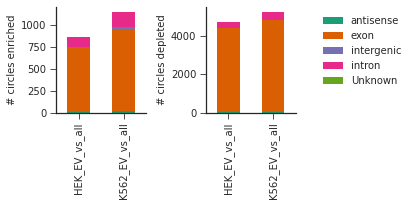

In [33]:
f, ax = plt.subplots(1,2, figsize = (6,3))
pos_cnt.loc[:, pos_cnt.columns.str.contains('_vs_all')&(~pos_cnt.columns.str.contains('HepG2'))].T.plot.bar(stacked = True, ax = ax[0],legend = False)
neg_cnt.loc[:, neg_cnt.columns.str.contains('_vs_all')&(~neg_cnt.columns.str.contains('HepG2'))].T.plot.bar(stacked = True, ax = ax[1])
ax[0].set_ylabel('# circles enriched')
ax[1].set_ylabel('# circles depleted')
ax[1].legend(bbox_to_anchor = (1.2,1))
sns.despine()
plt.tight_layout()
plt.savefig(figdir/'EV_deseq_compare_to_whole_cell.pdf')

# Compare to Sam Landry

In [50]:
sam_landry = {}
sam_landry_dir = Path('/tscc/nfs/home/slandry/projects/EV_RNA/Expt62_retro_analysis/Sequencing_Data_Analysis/')
for f in sam_landry_dir.glob('EV_*_gene_list.txt'):
    if 'k562' in str(f) or 'hek' in str(f) or 'hepg2' in str(f):
        sam = pd.read_csv(f, index_col = 0)
        sam.columns = ['ensembl_gene_id_version','log2fc','gene_name']
        sam_landry[f.name.split('_')[1]]=set(sam['gene_name'])

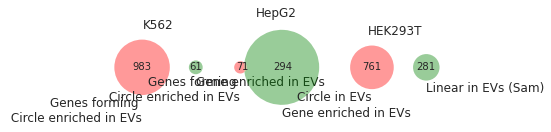

In [51]:
from matplotlib_venn import venn2
f, axes = plt.subplots(1,3, figsize = (6,2))
venn2([set(de_dict['K562_EV_vs_all'].loc[de_dict['K562_EV_vs_all']['DE']==1,'gene_name']),
       sam_landry['k562']],
     set_labels = ('Genes forming \n Circle enriched in EVs', 'Gene enriched in EVs'),
      ax = axes[0])
axes[0].set_title('K562')

venn2([set(de_dict['HepG2_EV_vs_all'].loc[de_dict['HepG2_EV_vs_all']['DE']==1,'gene_name']),
       sam_landry['hepg2']],
     set_labels = ('Genes forming \n Circle enriched in EVs', 'Gene enriched in EVs'),             
     ax = axes[1])
axes[1].set_title('HepG2')

venn2([set(de_dict['HEK_EV_vs_all'].loc[de_dict['HEK_EV_vs_all']['DE']==1,'gene_name']),
       sam_landry['hek']],
     set_labels = ('Circle in EVs', 'Linear in EVs (Sam)'),
            ax = axes[2]       
     )
axes[2].set_title('HEK293T')
plt.savefig(figdir/'EV_venn_compare_gene_to_linear.pdf')

# Are EVs more similar to cell lines?

In [27]:
# basedir = Path('/tscc/nfs/home/hsher/scratch/circ_nextera_iter12')


# ciri_stat_2 = pd.read_csv(basedir/'output/circle_summary/ciri_stats.csv').set_index('##Sample')
# circ_counts_2 = pd.read_csv(basedir/'output/circle_summary/circ_type_counts.csv', index_col = 0)

# bsj_2 = pd.read_csv(basedir/'output/circle_summary/BSJ_counts.csv', index_col = 0)
# fsj_2 = pd.read_csv(basedir/'output/circle_summary/FSJ_counts.csv', index_col = 0)
# bsj_cpm_2=bsj_2.div(ciri_stat_2['##Total_Reads'], axis = 1)*10**6
# fsj_cpm_2=fsj_2.div(ciri_stat_2['##Total_Reads'], axis = 1)*10**6

In [28]:
# all_bsj_cpm = pd.concat([bsj_cpm_2, bsj_cpm], axis = 1)
# all_fsj_cpm = pd.concat([fsj_cpm_2, fsj_cpm], axis = 1)

Text(0.5, 0.98, 'PCA by BSJ CPM')

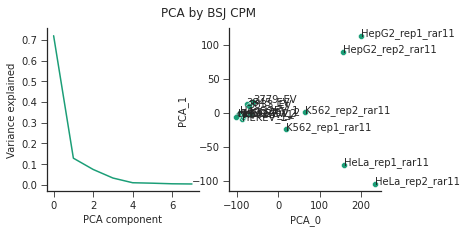

In [29]:
# fraction_detected = 0.5
# ncomp = min(8,all_bsj_cpm.shape[1]-1)
# common_circ = all_bsj_cpm.loc[all_bsj_cpm.count(axis = 1)>all_bsj_cpm.shape[1]*fraction_detected].fillna(0)
# pca = PCA(n_components=ncomp)
# transformed = pca.fit_transform(common_circ.T)
# transformed_df = pd.DataFrame(transformed, index = all_bsj_cpm.columns, columns = [f'PCA_{i}' for i in range(ncomp)])

# f, ax = plt.subplots(1,2, figsize = (6,3))
# ax[0].plot(pca.explained_variance_ratio_)
# ax[0].set_ylabel('Variance explained')
# ax[0].set_xlabel('PCA component')

# sns.scatterplot(data = transformed_df, x = 'PCA_0', y = 'PCA_1', ax = ax[1])
# for index, row in transformed_df.iterrows():
#     ax[1].text(row['PCA_0'], row['PCA_1'], index)
# sns.despine()
# plt.suptitle('PCA by BSJ CPM')

# Are the cell line specific EV circles also present in 1 cell type

In [30]:
# from scipy.spatial.distance import pdist, squareform
# def compute_jaccard_index(identity_tbl):
#     ''' use jaccard index to show how much binding site overlapped between RBPs'''
#     d_condense = pdist(identity_tbl.T, 'jaccard')
#     d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
#     return d

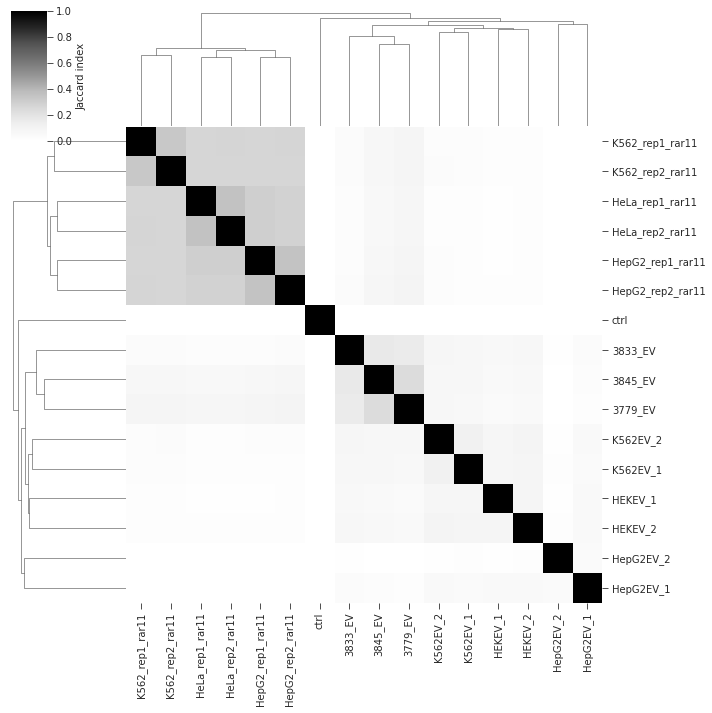

In [31]:
# identity_tbl = ~all_bsj_cpm.isnull()
# sns.clustermap(compute_jaccard_index(identity_tbl),
#               cmap = 'Greys',
#               cbar_kws = {'label': 'Jaccard index'})

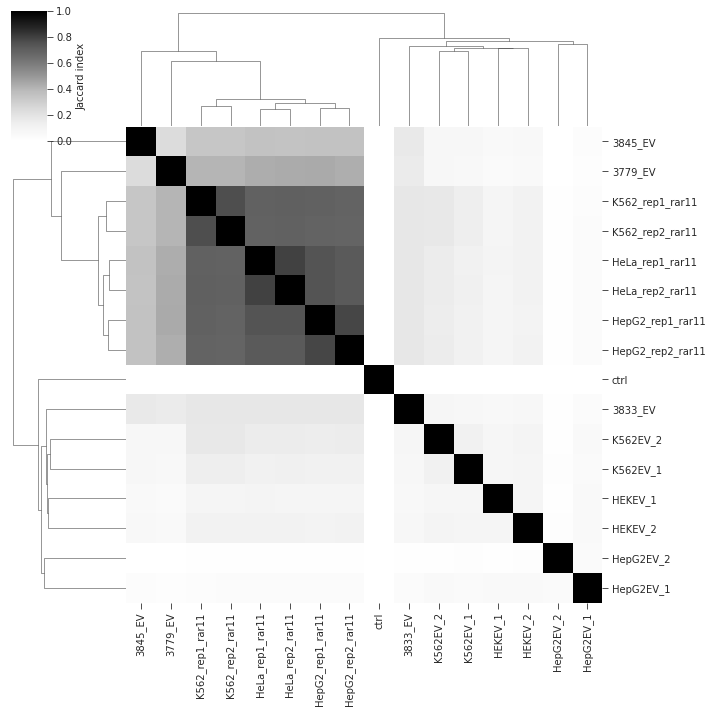

In [32]:
# sns.clustermap(compute_jaccard_index(identity_tbl.loc[bsj.index]),
#               cmap = 'Greys',
#               cbar_kws = {'label': 'Jaccard index'})

<AxesSubplot:xlabel='HepG2EV_1', ylabel='HepG2EV_2'>

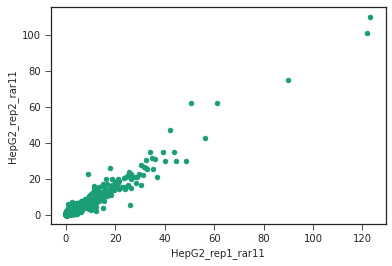

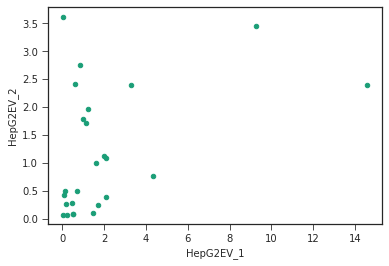

In [33]:
# all_bsj_cpm.plot.scatter(x = 'HepG2_rep1_rar11', y='HepG2_rep2_rar11')
# all_bsj_cpm.plot.scatter(x = 'HepG2EV_1', y='HepG2EV_2')

<AxesSubplot:xlabel='HepG2EV_1', ylabel='HepG2_rep1_rar11'>

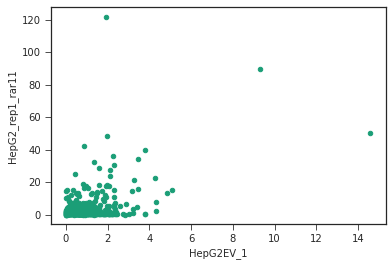

In [34]:
# all_bsj_cpm.plot.scatter(x = 'HepG2EV_1', y='HepG2_rep1_rar11')

<AxesSubplot:xlabel='HEKEV_1', ylabel='HepG2_rep1_rar11'>

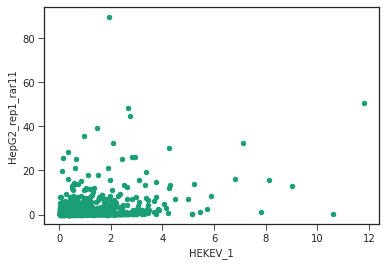

In [35]:
# all_bsj_cpm.plot.scatter(x = 'HEKEV_1', y='HepG2_rep1_rar11')

In [36]:
# placental only EV
# find unique placetal, placental -specific RNA expressed gene